<a href="https://colab.research.google.com/github/ambikad04/FL-PrivacyPreserving-HealthcareAnalytics/blob/test%2Fattack-check/PrivacyPreserving_HealthcareAnalytics_withAttacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries Used

The following libraries are essential for implementing a basic neural network classification script:

---

### Libraries Overview

- **`torch`**: Core library for tensor computations, with GPU support for deep learning tasks.  
- **`torch.nn`**: Provides layers and modules to build neural networks.  
- **`torch.optim`**: Includes optimization algorithms like SGD and Adam for training models.  
- **`torch.nn.functional`**: Functional API for activation functions and loss calculations.  
- **`numpy`**: Handles numerical computations and array operations efficiently.  
- **`matplotlib.pyplot`**: Visualizes data and model performance with graphs and plots.  
- **`seaborn`**: Enhances visualizations with clean and informative statistical plots.  
- **`sklearn.datasets.make_classification`**: Generates synthetic datasets for classification tasks.  
- **`sklearn.model_selection.train_test_split`**: Splits data into training and testing sets for model evaluation.

---

These libraries enable building, training, and visualizing a simple neural network for classification using synthetic data.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

### Fully Connected Model with Batch Normalization and Dropout

This code defines a neural network model called **`AdvancedFCModel`** using PyTorch. It is a fully connected (FC) network with additional techniques like batch normalization and dropout to improve training stability and prevent overfitting.


---

1. **Layers**:
   - **Layer 1**: 64 neurons → Normalize (BatchNorm) → Activate (ReLU) → Dropout (30%).  
   - **Layer 2**: 32 neurons → Normalize → Activate → Dropout.  
   - **Layer 3**: 1 neuron → Sigmoid (gives a probability between 0 and 1).

2. **Techniques**:
   - **Batch Normalization**: Helps the model train faster and work better.  
   - **Dropout**: Randomly ignores some neurons to avoid overfitting.

---

This model processes input data through the layers to predict probabilities for binary classification tasks.

In [2]:
# Define a Fully Connected Model with BatchNorm and Dropout
class AdvancedFCModel(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedFCModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


### Creating Synthetic Healthcare Data

This code generates and splits sample data for binary classification tasks:

1. **Generate Data**:  
   - **`make_classification`** creates a dataset with 100 samples and 10 features (8 useful for classification).  
   - The data is designed for two classes (binary output).

2. **Split Data**:  
   - **`train_test_split`** splits the dataset into 80% for training and 20% for testing.  

This dataset simulates healthcare-related data for testing models.

In [3]:
# Create Synthetic Data (Healthcare)
X, y = make_classification(n_samples=100, n_features=10, n_informative=8, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Simulating Client Data

This code splits the dataset into smaller parts to simulate data for 5 clients:

1. **Training Data**:  
   - The training set is divided into 5 parts, each containing 20 samples.

2. **Testing Data**:  
   - The test set is divided into 5 parts, each containing 5 samples.

Each client gets a portion of the training and testing data, stored as PyTorch tensors for easy model usage.

In [4]:
# Simulate Client Data (Split data into 5 clients)
clients_data = [(torch.tensor(X_train[i:i+20], dtype=torch.float32), torch.tensor(y_train[i:i+20], dtype=torch.float32)) for i in range(0, 80, 20)]
clients_data_test = [(torch.tensor(X_test[i:i+5], dtype=torch.float32), torch.tensor(y_test[i:i+5], dtype=torch.float32)) for i in range(0, 20, 5)]

### Training Local Model on Each Client

This function trains a model locally on client data:

1. **Inputs**:  
   - `model`: The neural network to train.  
   - `data` and `targets`: The client's training data and labels.  
   - `epochs`: Number of training cycles (default is 5).

2. **Steps**:  
   - Use **`BCELoss`** (binary cross-entropy) as the loss function.  
   - Optimize using **SGD** (stochastic gradient descent) with a learning rate of 0.01.  
   - Adjust the learning rate every 3 epochs using a scheduler.

3. **Process**:  
   - Forward pass to compute outputs.  
   - Calculate loss, backpropagate, and update weights.  
   - Track the loss for each epoch.

4. **Output**:  
   - Returns the model’s updated parameters and a history of loss values.  

In [5]:
# Train Local Model on Each Client
def train_local_model(model, data, targets, epochs=5):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_history.append(loss.item())
    return model.state_dict(), loss_history


### Federated Averaging

This function updates the global model by combining weights from all client models:

1. **Inputs**:  
   - `global_model`: The shared model used by all clients.  
   - `local_models_weights`: A list of weights from each client's model.

2. **How It Works**:  
   - Take the weights of the global model.  
   - For each layer, calculate the average of the same weights from all client models.  
   - Update the global model with these averaged weights.

This allows the global model to learn from all clients without using their data directly.

In [6]:
# Federated Averaging
def federated_averaging(global_model, local_models_weights):
    global_state_dict = global_model.state_dict()
    for key in global_state_dict:
        global_state_dict[key] = torch.mean(torch.stack([local_weights[key] for local_weights in local_models_weights]), dim=0)
    global_model.load_state_dict(global_state_dict)

### Distributed Backdoor Attack

This function adds a backdoor attack to the local model weights:

1. **Inputs**:  
   - `local_weights`: The weights of the client's model.  
   - `trigger_value`: The strength of the backdoor attack (default is 0.5).

2. **How It Works**:  
   - Check if the weights are not in **float32** format, and convert them if needed.  
   - Add random noise to the weights, scaled by the **trigger_value**, to create the attack.

This makes the local model behave incorrectly when triggered by certain inputs.

In [7]:
def distributed_backdoor_attack(local_weights, trigger_value=0.5):
    for key in local_weights:
        if local_weights[key].dtype != torch.float32:
            local_weights[key] = local_weights[key].float()  # Convert to float if not already
        local_weights[key] += torch.randn_like(local_weights[key]) * trigger_value
    return local_weights


### Krum Defense

This function selects the model that is least affected by outliers (to defend against attacks):

1. **Inputs**:  
   - `local_models_weights`: Weights from all client models.

2. **How It Works**:  
   - For each model, calculate the distance to all other models.  
   - For each pair, compute the difference in weights and sum the distances.  
   - Select the model with the smallest total distance, which is considered the most trustworthy.

This method helps protect against malicious models by choosing the one that is most similar to others.

In [8]:
# Krum Defense
def krum_aggregation(local_models_weights):
    distances = []
    for i, weights_i in enumerate(local_models_weights):
        dist_sum = []
        for j, weights_j in enumerate(local_models_weights):
            if i != j:
                dist = sum(torch.norm(weights_i[k] - weights_j[k]) for k in weights_i)
                dist_sum.append(dist.item())
        distances.append((i, sum(sorted(dist_sum)[:len(local_models_weights) - 2])))  # Krum distance
    selected_idx = min(distances, key=lambda x: x[1])[0]
    return local_models_weights[selected_idx]

### Model Poisoning Attack

This function adds a poisoning attack to the local model weights:

1. **Inputs**:  
   - `local_weights`: The weights of the client's model.  
   - `poison_factor`: The strength of the attack (default is 10.0).

2. **How It Works**:  
   - Multiply each weight by the **poison_factor**, making the model behave incorrectly.

This attack manipulates the model's weights to disrupt its performance.

In [9]:
# Model Poisoning Attack
def model_poisoning_attack(local_weights, poison_factor=10.0):
    for key in local_weights:
        local_weights[key] *= poison_factor
    return local_weights

### Model Replacement Attack

This function replaces the global model's weights with malicious ones:

1. **Inputs**:  
   - `global_weights`: Weights of the global model.  
   - `malicious_weights`: Weights from a malicious model.

2. **How It Works**:  
   - Replace each weight in the global model with the corresponding weight from the malicious model.

This attack completely replaces the global model with a harmful one.

In [10]:
# Model Replacement Attack
def model_replacement_attack(global_weights, malicious_weights):
    for key in global_weights:
        global_weights[key] = malicious_weights[key]
    return global_weights


### Trimmed Mean Defense

This function combines model weights using the trimmed mean to remove outliers:

1. **Inputs**:  
   - `local_models_weights`: Weights from all client models.  
   - `trim_ratio`: The percentage of outliers to remove (default is 10%).

2. **How It Works**:  
   - For each weight, sort the values from all models.  
   - Remove the top and bottom **trim_ratio**% of the values (outliers).  
   - Calculate the mean of the remaining weights.

This defense method helps avoid the impact of malicious or faulty models by focusing on the majority of the weights.

In [11]:
# Trimmed Mean Defense
def trimmed_mean_aggregation(local_models_weights, trim_ratio=0.1):
    global_weights = {}
    for key in local_models_weights[0]:
        stacked_weights = torch.stack([weights[key] for weights in local_models_weights])
        sorted_weights, _ = torch.sort(stacked_weights, dim=0)
        trim_size = int(trim_ratio * sorted_weights.size(0))
        trimmed_weights = sorted_weights[trim_size:-trim_size]
        global_weights[key] = torch.mean(trimmed_weights, dim=0)
    return global_weights

### Inner Product Manipulation Attack (IPM)

This function manipulates the model's weights by scaling them:

1. **Inputs**:  
   - `local_weights`: Weights of the client's model.  
   - `manipulation_factor`: A factor that controls how much to change the weights (default is -1.0).

2. **How It Works**:  
   - Multiply each weight by the **manipulation_factor** to alter the model.

This attack intentionally changes the model’s weights to disrupt its behavior.

In [12]:
# Inner Product Manipulation Attack (IPM)
def inner_product_manipulation(local_weights, manipulation_factor=-1.0):
    for key in local_weights:
        local_weights[key] *= manipulation_factor
    return local_weights


### Initialize the Global Model

This code creates the global model:

1. **Inputs**:  
   - `input_dim`: The number of features in the training data (`X_train`).

2. **How It Works**:  
   - The `global_model` is initialized using the **`AdvancedFCModel`** class with the input dimensions.

This sets up the model that will be shared across clients for training.

In [13]:
# Initialize the Global Model
input_dim = X_train.shape[1]
global_model = AdvancedFCModel(input_dim)

### Federated Learning Process (10 Rounds)

This code simulates 10 rounds of federated learning with some malicious clients:

1. **Inputs**:  
   - `clients_data`: Data from each client for training.  
   - `malicious_clients`: A list of clients simulating attacks.

2. **Steps**:  
   - **Each Round**:  
     1. Each client trains on its own data using the global model.  
     2. If the client is malicious, apply a backdoor attack to its model.  
     3. Collect the local models' weights and track their loss.
   
   - **Federated Averaging**:  
     After each round, average the weights from all clients and update the global model.
   
   - **Testing**:  
     Test the global model on the client data to calculate accuracy.

3. **Output**:  
   - After each round, print the accuracy of the global model.

This process helps train a shared model while simulating attacks and defenses.

In [14]:
# Federated Learning Process (10 rounds)
loss_curves = []
accuracy_history = []
malicious_clients = [0, 2]  # Simulate malicious clients

for round in range(10):
    print(f"Round {round + 1}")
    local_models_weights = []
    round_loss_curves = []

    # Each client trains on its local data
    for idx, (client_data, client_targets) in enumerate(clients_data):
        local_model = AdvancedFCModel(input_dim)
        local_model.load_state_dict(global_model.state_dict())
        local_weights, loss_history = train_local_model(local_model, client_data, client_targets)

        if idx in malicious_clients:
            # Apply chosen attack (e.g., DBA)
            local_weights = distributed_backdoor_attack(local_weights)

        local_models_weights.append(local_weights)
        round_loss_curves.append(loss_history)

    loss_curves.append(round_loss_curves)

    # Federated Averaging
    federated_averaging(global_model, local_models_weights)

    # Testing the model on client data
    global_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for client_data, client_targets in clients_data_test:
            outputs = global_model(client_data)
            predicted = (outputs.squeeze() > 0.5).float()
            total += client_targets.size(0)
            correct += (predicted == client_targets).sum().item()
        accuracy = correct / total
        accuracy_history.append(accuracy)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")


Round 1
Test Accuracy: 40.00%
Round 2
Test Accuracy: 50.00%
Round 3
Test Accuracy: 40.00%
Round 4
Test Accuracy: 50.00%
Round 5
Test Accuracy: 45.00%
Round 6
Test Accuracy: 50.00%
Round 7
Test Accuracy: 45.00%
Round 8
Test Accuracy: 55.00%
Round 9
Test Accuracy: 50.00%
Round 10
Test Accuracy: 45.00%


### Visualization of Loss Curves

This code plots the average loss curves for each client during training:

1. **Steps**:  
   - For each client, calculate the average loss across all rounds.
   - Plot the loss against the number of epochs.

2. **Output**:  
   - Display a graph showing the loss curve for each client during training.

This helps visualize how the clients' models performed over time.

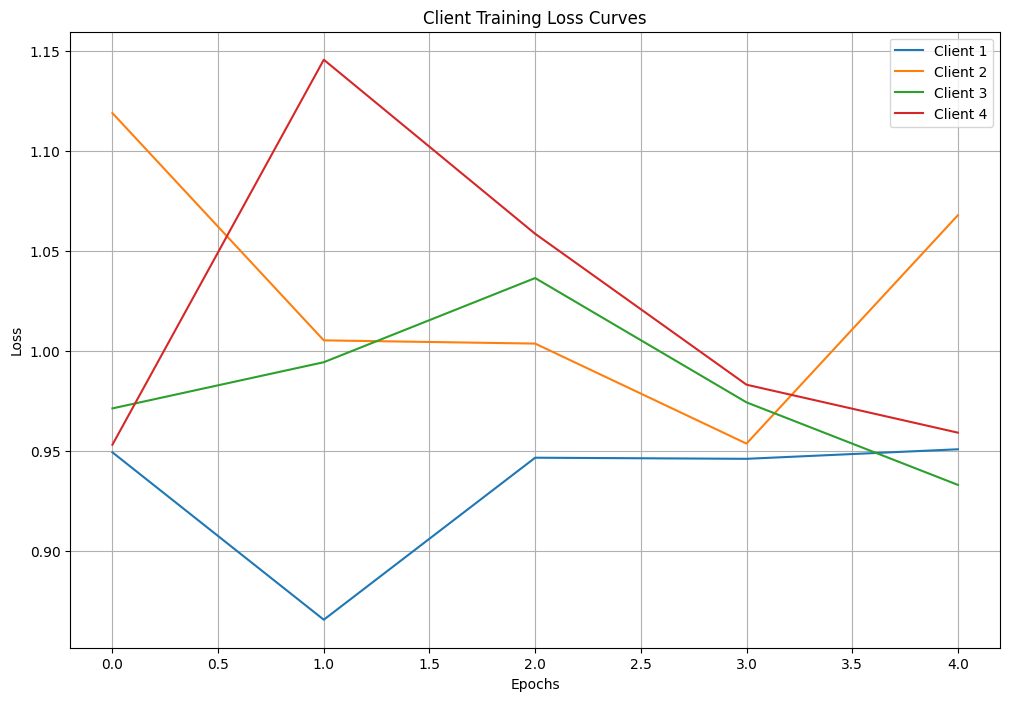

In [15]:
# Visualization of Loss Curves
plt.figure(figsize=(12, 8))
for client_idx, client_losses in enumerate(zip(*loss_curves)):
    avg_client_loss = np.mean(client_losses, axis=0)
    plt.plot(avg_client_loss, label=f'Client {client_idx + 1}')
plt.title('Client Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Visualization of Test Accuracy

This code plots the global model's test accuracy over 10 rounds:

1. **Steps**:  
   - Plot the accuracy for each round, showing how it changes with each round of federated learning.

2. **Output**:  
   - Display a graph with accuracy on the y-axis and rounds on the x-axis.

This helps track the performance of the global model during training.

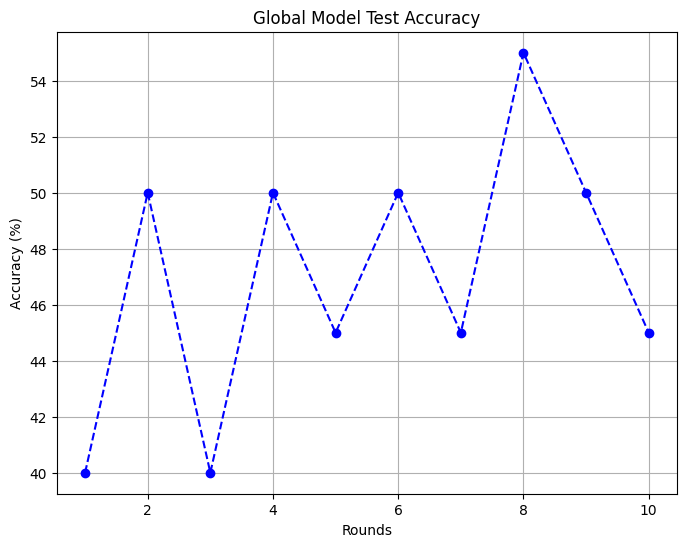

In [16]:
# Visualization of Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), [acc * 100 for acc in accuracy_history], marker='o', linestyle='--', color='b')
plt.title('Global Model Test Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

### Heatmap of Client Loss Trends

This code creates a heatmap showing how the loss trends of each client change across rounds:

1. **Steps**:  
   - Calculate the average loss for each client in each round.  
   - Create a matrix where each row represents a round and each column represents a client.
   
2. **Output**:  
   - Display a heatmap with colors representing the loss values. Darker shades indicate higher losses.

This helps visualize how the clients' losses evolve over the rounds.

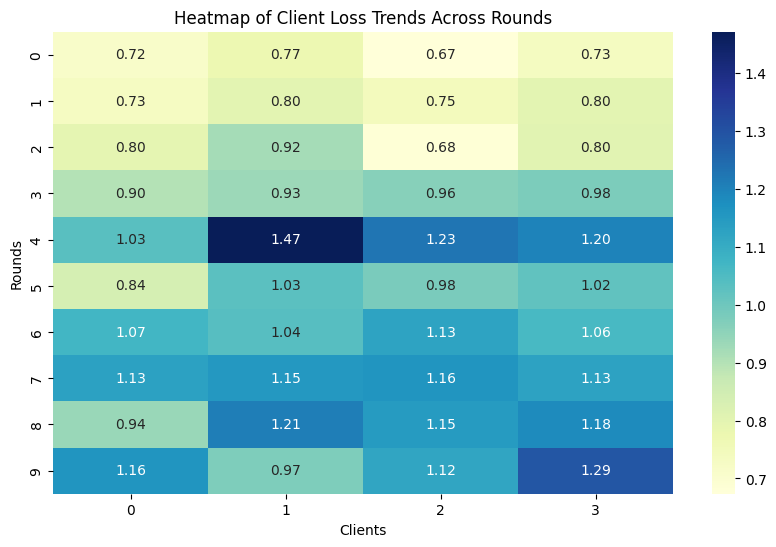

In [17]:
# Heatmap of Client Loss Trends
loss_matrix = np.array([[np.mean(client_losses) for client_losses in round_losses] for round_losses in loss_curves])
plt.figure(figsize=(10, 6))
sns.heatmap(loss_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Heatmap of Client Loss Trends Across Rounds")
plt.xlabel("Clients")
plt.ylabel("Rounds")
plt.show()

### Overlayed Accuracy and Loss Trends

This code shows both accuracy and loss trends in the same graph:

1. **Steps**:  
   - Calculate the average loss for each round.  
   - Plot the accuracy and average loss on the same graph, with different markers and colors.

2. **Output**:  
   - Display a graph with accuracy (green) and average loss (red) across rounds.

This helps compare how accuracy and loss change together over time.

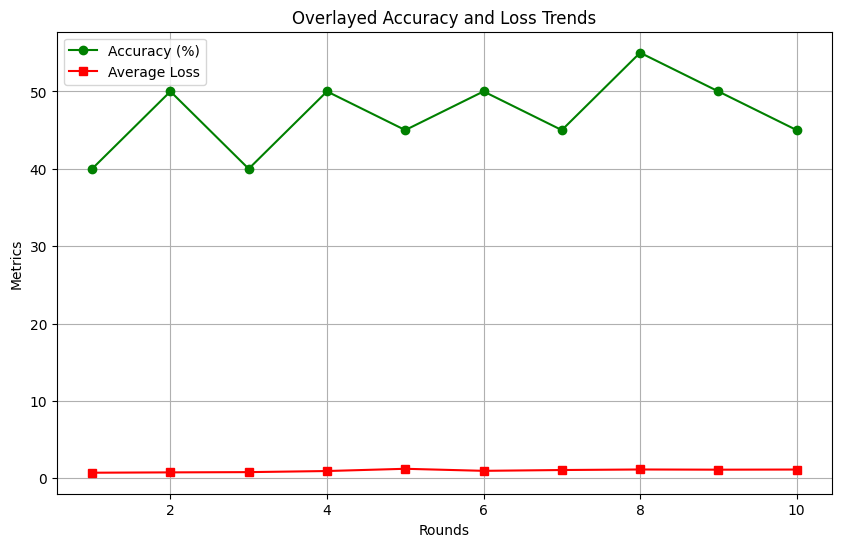

In [18]:
# Overlayed Accuracy and Loss Trends
avg_loss_per_round = [np.mean([np.mean(client_losses) for client_losses in round_losses]) for round_losses in loss_curves]
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), [acc * 100 for acc in accuracy_history], marker='o', label='Accuracy (%)', color='g')
plt.plot(range(1, 11), avg_loss_per_round, marker='s', label='Average Loss', color='r')
plt.title("Overlayed Accuracy and Loss Trends")
plt.xlabel("Rounds")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()